dat shape (neurons x trials): (39209, 5900)

PCA: 15 components explain ≥90% of the variance in the test set.


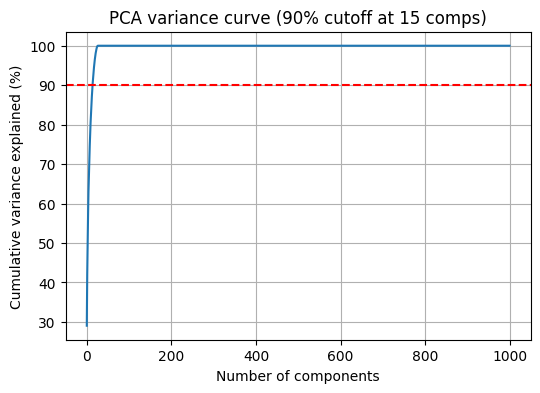


Computed metrics for 500 neurons.
At FDR=0.05, 2/500 neurons show AUC > 0.5 (significant).


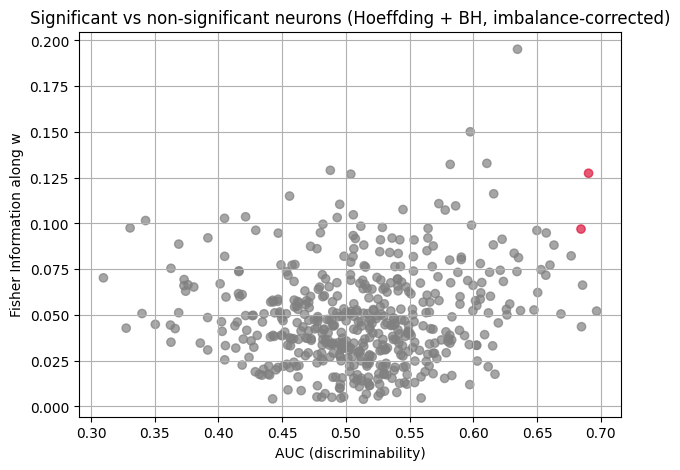


Summary statistics:
                     mean           std           min           max
neuron_idx   19525.856000  11244.473146  2.070000e+02  39154.000000
AUC              0.511915      0.064887  3.097151e-01      0.696717
Advantage        0.023829      0.129773 -3.805698e-01      0.393435
FI_trace       233.056953     10.022081  1.579719e+02    247.636942
FI_along_w       0.048515      0.026426  3.933911e-03      0.195228
EffectiveFI      0.001644      0.008811 -3.304013e-02      0.052569
m_pos           68.450000     52.662645  1.200000e+01    367.000000
n_neg         1331.550000     52.662645  1.033000e+03   1388.000000
p_value          0.831841      0.271589  7.683413e-07      1.000000
p_adj            0.987850      0.102947  3.841707e-04      1.000000

Top 10 significant neurons (imbalance-corrected):
     neuron_idx       AUC  m_pos  n_neg       p_value     p_adj
78        32302  0.690380    233   1167  7.683413e-07  0.000384
100       27167  0.684463    191   1209  1.333879e-0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from skbio.stats.composition import clr
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from sklearn.exceptions import ConvergenceWarning
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
import pickle, warnings

# ---------------------------------------------------------------
#  Setup
# ---------------------------------------------------------------
warnings.filterwarnings("ignore", category=ConvergenceWarning)
rng = np.random.default_rng(42)

# ---------------------------------------------------------------
#  Load data
# ---------------------------------------------------------------
dat = np.load('/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy')
print("dat shape (neurons x trials):", dat.shape)

path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

embeddings = np.stack(list(vit_dict))          # (118, 1000)
X = softmax(embeddings, axis=1)                # convert to probabilities

# ---------------------------------------------------------------
#  Trial structure
# ---------------------------------------------------------------
n_neurons, n_samples = dat.shape
n_images = 118
n_trials = 50
assert n_samples == n_images * n_trials

# Split by image identity (avoid leakage across trials)
img_indices = np.arange(n_images)
img_train, img_test = train_test_split(img_indices, test_size=28, random_state=42)
train_mask = np.isin(np.repeat(np.arange(n_images), n_trials), img_train)
test_mask  = np.isin(np.repeat(np.arange(n_images), n_trials), img_test)

# ---------------------------------------------------------------
#  Transform data
# ---------------------------------------------------------------
Y_binary = (dat > 0).astype(int)        # spike indicator
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)

# ---------------------------------------------------------------
#  Helper functions
# ---------------------------------------------------------------
def fisher_information_from_logreg(model, X):
    """Compute Fisher Information matrix for fitted logistic regression."""
    p = model.predict_proba(X)[:, 1]
    W = np.diag(p * (1 - p))
    return X.T @ W @ X / len(X)

def classifier_advantage(y_true, y_prob):
    """Return AUC and classifier advantage (2*(AUC-0.5))."""
    auc = roc_auc_score(y_true, y_prob)
    return auc, 2 * (auc - 0.5)

def hoeffding_pvalue(auc, m, n):
    """One-sided conservative p-value for H0: AUC <= 0.5."""
    delta = max(auc - 0.5, 0)
    if delta <= 0 or m == 0 or n == 0:
        return 1.0
    exponent = -2 * delta**2 / (1/m + 1/n)
    return float(np.exp(exponent))

# ---------------------------------------------------------------
#  Global PCA (before per-neuron loop)
# ---------------------------------------------------------------
pca_full = PCA()
pca_full.fit(X_trials_clr[test_mask])
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cum_var >= 0.90) + 1
print(f"\nPCA: {n_components_90} components explain ≥90% of the variance in the test set.")

# Fit PCA on training data (with that fixed dimensionality)
pca = PCA(n_components=n_components_90)
pca.fit(X_trials_clr[train_mask])

# Transform once
X_train_pca = pca.transform(X_trials_clr[train_mask])
X_test_pca  = pca.transform(X_trials_clr[test_mask])

# Optional visualization of explained variance
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_)*100)
plt.axhline(90, color='r', linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance explained (%)')
plt.title(f'PCA variance curve (90% cutoff at {n_components_90} comps)')
plt.grid(True)
plt.show()

# ---------------------------------------------------------------
#  Run per-neuron logistic regressions
# ---------------------------------------------------------------
sampled_neurons = rng.choice(np.arange(n_neurons), size=500, replace=False)
results = []

for idx in sampled_neurons:
    y = Y_binary[idx]
    if y.sum() < 10 or y.sum() > len(y) - 10:
        continue

    y_train, y_test = y[train_mask], y[test_mask]

    model = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        penalty='l2',
        solver='liblinear'
    )

    try:
        model.fit(X_train_pca, y_train)
    except Exception:
        continue

    y_prob = model.predict_proba(X_test_pca)[:, 1]
    auc, adv = classifier_advantage(y_test, y_prob)

    I = fisher_information_from_logreg(model, X_train_pca)
    w = model.coef_.ravel()
    FI_trace = np.trace(I)
    FI_along_w = float(w @ I @ w)
    EffectiveFI = FI_along_w * (2 * auc - 1)

    m_pos = y_test.sum()
    n_neg = len(y_test) - m_pos
    p_val = hoeffding_pvalue(auc, m_pos, n_neg)

    results.append({
        "neuron_idx": idx,
        "AUC": auc,
        "Advantage": adv,
        "FI_trace": FI_trace,
        "FI_along_w": FI_along_w,
        "EffectiveFI": EffectiveFI,
        "m_pos": m_pos,
        "n_neg": n_neg,
        "p_value": p_val
    })

# ---------------------------------------------------------------
#  Analysis: Benjamini–Hochberg correction
# ---------------------------------------------------------------
df = pd.DataFrame(results)
print(f"\nComputed metrics for {len(df)} neurons.")

alpha = 0.05
reject, pvals_corrected, _, _ = multipletests(df["p_value"], alpha=alpha, method="fdr_bh")
df["p_adj"] = pvals_corrected
df["significant"] = reject

n_sig = df["significant"].sum()
print(f"At FDR={alpha}, {n_sig}/{len(df)} neurons show AUC > 0.5 (significant).")

# ---------------------------------------------------------------
#  Visualization
# ---------------------------------------------------------------
plt.figure(figsize=(7,5))
plt.scatter(df["AUC"], df["FI_along_w"],
            c=df["significant"].map({True:"crimson", False:"gray"}),
            alpha=0.7)
plt.xlabel("AUC (discriminability)")
plt.ylabel("Fisher Information along w")
plt.title("Significant vs non-significant neurons (Hoeffding + BH, imbalance-corrected)")
plt.grid(True)
plt.show()

# ---------------------------------------------------------------
#  Reports
# ---------------------------------------------------------------
print("\nSummary statistics:")
print(df.describe().T[["mean","std","min","max"]])

sig_neurons = df[df["significant"]].sort_values("AUC", ascending=False)
print("\nTop 10 significant neurons (imbalance-corrected):")
print(sig_neurons.head(10)[["neuron_idx", "AUC", "m_pos", "n_neg", "p_value", "p_adj"]])

top_clean = df.sort_values("EffectiveFI", ascending=False).head(10)
print("\nTop 10 cleanest neurons (high AUC & FI):")
print(top_clean[["neuron_idx","AUC","FI_along_w","EffectiveFI"]])


Using device: cuda
dat shape (neurons x trials): (39209, 5900)

Training SAE on CLR features (train trials only)...
Epoch   1/60 | loss=0.58420 | rec=0.58373 | l1=0.46906
Epoch  10/60 | loss=0.00132 | rec=0.00066 | l1=0.65630
Epoch  20/60 | loss=0.00077 | rec=0.00023 | l1=0.53560
Epoch  30/60 | loss=0.00051 | rec=0.00006 | l1=0.44860
Epoch  40/60 | loss=0.00332 | rec=0.00292 | l1=0.40131
Epoch  50/60 | loss=0.00053 | rec=0.00018 | l1=0.35677
Epoch  60/60 | loss=0.00183 | rec=0.00150 | l1=0.33477
SAE latent shapes: train (4500, 500), test (1400, 500)

Computed metrics for 500 neurons using SAE(500) features.
At FDR=0.05, 0/500 neurons show AUC > 0.5 (significant).


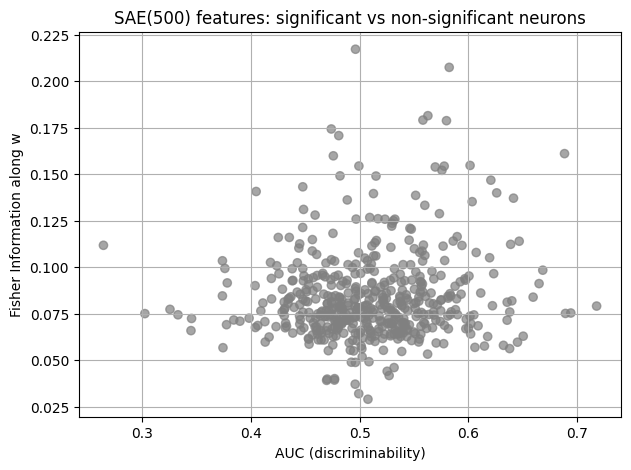


Summary statistics (SAE features):
                     mean           std          min           max
neuron_idx   19525.856000  11244.473146   207.000000  39154.000000
AUC              0.510186      0.061227     0.264111      0.717883
Advantage        0.020372      0.122454    -0.471778      0.435766
FI_trace        65.189679     11.499010    21.928900     90.368380
FI_along_w       0.083932      0.024443     0.029017      0.217098
EffectiveFI      0.002024      0.011169    -0.052714      0.060646
m_pos           68.450000     52.662645    12.000000    367.000000
n_neg         1331.550000     52.662645  1033.000000   1388.000000
p_value          0.845817      0.256356     0.001757      1.000000
p_adj            0.999757      0.005430     0.878580      1.000000

Top 10 significant neurons (SAE features):
Empty DataFrame
Columns: [neuron_idx, AUC, m_pos, n_neg, p_value, p_adj]
Index: []

Top 10 cleanest neurons (high AUC & FI, SAE features):
     neuron_idx       AUC  FI_along_w  Effec

In [3]:
# ============================
# SAE (Sparse Autoencoder) pipeline on CLR features → neural prediction
# ============================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from skbio.stats.composition import clr
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from sklearn.exceptions import ConvergenceWarning
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
import pickle, warnings, math, os

# Torch for SAE
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ---------------------------------------------------------------
#  Setup
# ---------------------------------------------------------------
warnings.filterwarnings("ignore", category=ConvergenceWarning)
rng = np.random.default_rng(42)
torch.manual_seed(42)
np.random.seed(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

SAE_DIM = 500          # latent size requested
SAE_EPOCHS = 60
SAE_BATCH = 256
SAE_LR = 1e-3
SAE_L1 = 1e-3          # L1 penalty on hidden activations (tune if you want sparser)

# ---------------------------------------------------------------
#  Load data
# ---------------------------------------------------------------
dat = np.load('/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy')
print("dat shape (neurons x trials):", dat.shape)

path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

embeddings = np.stack(list(vit_dict))          # (118, 1000)
X = softmax(embeddings, axis=1)                # convert to probabilities

# ---------------------------------------------------------------
#  Trial structure
# ---------------------------------------------------------------
n_neurons, n_samples = dat.shape
n_images = 118
n_trials = 50
assert n_samples == n_images * n_trials

# Split by image identity (avoid leakage across trials)
img_indices = np.arange(n_images)
img_train, img_test = train_test_split(img_indices, test_size=28, random_state=42)
train_mask = np.isin(np.repeat(np.arange(n_images), n_trials), img_train)
test_mask  = np.isin(np.repeat(np.arange(n_images), n_trials), img_test)

# ---------------------------------------------------------------
#  Transform data (CLR + repeat to trials)
# ---------------------------------------------------------------
Y_binary = (dat > 0).astype(int)        # spike indicator per neuron per trial
X_clr = clr(X + 1e-12)                  # (118, 1000), zero-sum rows
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)  # (118*50, 1000)

# ---------------------------------------------------------------
#  SAE model
# ---------------------------------------------------------------
class SAE(nn.Module):
    def __init__(self, d_in: int, d_latent: int):
        super().__init__()
        # 1-hidden-layer linear AE with ReLU encoder; linear decoder
        self.enc = nn.Sequential(
            nn.Linear(d_in, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, d_latent),
            nn.ReLU(inplace=True),
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, d_in)
        )

    def forward(self, x):
        h = self.enc(x)
        x_hat = self.dec(h)
        return x_hat, h

def train_sae(X_train: np.ndarray, d_latent: int, epochs=SAE_EPOCHS, batch=SAE_BATCH,
              lr=SAE_LR, l1=SAE_L1, device=DEVICE):
    d_in = X_train.shape[1]
    model = SAE(d_in, d_latent).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    # Standardize inputs for stability; fit on train only
    scaler = StandardScaler(with_mean=True, with_std=True)
    X_train_std = scaler.fit_transform(X_train)

    ds = TensorDataset(torch.from_numpy(X_train_std.astype(np.float32)))
    dl = DataLoader(ds, batch_size=batch, shuffle=True, drop_last=False)

    model.train()
    for ep in range(1, epochs+1):
        total_loss = 0.0
        total_rec  = 0.0
        total_l1   = 0.0
        for (xb,) in dl:
            xb = xb.to(device)
            x_hat, h = model(xb)
            rec = mse(x_hat, xb)
            l1_pen = torch.mean(torch.abs(h))  # average L1 on hidden activations
            loss = rec + l1 * l1_pen

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item() * xb.size(0)
            total_rec  += rec.item() * xb.size(0)
            total_l1   += l1_pen.item() * xb.size(0)

        n = len(ds)
        if ep % 10 == 0 or ep == 1 or ep == epochs:
            print(f"Epoch {ep:3d}/{epochs} | loss={total_loss/n:.5f} | rec={total_rec/n:.5f} | l1={total_l1/n:.5f}")

    return model, scaler

@torch.no_grad()
def encode(model: nn.Module, scaler: StandardScaler, X: np.ndarray, device=DEVICE):
    model.eval()
    X_std = scaler.transform(X)
    xb = torch.from_numpy(X_std.astype(np.float32)).to(device)
    _, h = model(xb)
    return h.cpu().numpy()

# ---------------------------------------------------------------
#  Fit SAE on TRAIN trials only; transform train & test
# ---------------------------------------------------------------
print("\nTraining SAE on CLR features (train trials only)...")
X_train_clr = X_trials_clr[train_mask]  # (n_train_trials, 1000)
X_test_clr  = X_trials_clr[test_mask]   # (n_test_trials, 1000)

sae_model, sae_scaler = train_sae(X_train_clr, d_latent=SAE_DIM)

Z_train = encode(sae_model, sae_scaler, X_train_clr)  # (n_train_trials, SAE_DIM)
Z_test  = encode(sae_model, sae_scaler, X_test_clr)   # (n_test_trials, SAE_DIM)

print(f"SAE latent shapes: train {Z_train.shape}, test {Z_test.shape}")

# ---------------------------------------------------------------
#  Helper functions (same diagnostics)
# ---------------------------------------------------------------
def fisher_information_from_logreg(model, X):
    """Compute Fisher Information matrix for fitted logistic regression."""
    p = model.predict_proba(X)[:, 1]
    W = np.diag(p * (1 - p))
    return X.T @ W @ X / len(X)

def classifier_advantage(y_true, y_prob):
    """Return AUC and classifier advantage (2*(AUC-0.5))."""
    auc = roc_auc_score(y_true, y_prob)
    return auc, 2 * (auc - 0.5)

def hoeffding_pvalue(auc, m, n):
    """One-sided conservative p-value for H0: AUC <= 0.5."""
    delta = max(auc - 0.5, 0)
    if delta <= 0 or m == 0 or n == 0:
        return 1.0
    exponent = -2 * delta**2 / (1/m + 1/n)
    return float(np.exp(exponent))

# ---------------------------------------------------------------
#  Run per-neuron logistic regressions on SAE features
# ---------------------------------------------------------------
sampled_neurons = rng.choice(np.arange(n_neurons), size=500, replace=False)
results = []

for idx in sampled_neurons:
    y = Y_binary[idx]
    if y.sum() < 10 or y.sum() > len(y) - 10:
        continue  # skip too imbalanced neurons

    y_train, y_test = y[train_mask], y[test_mask]

    model = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        penalty='l2',
        solver='liblinear'
    )

    try:
        model.fit(Z_train, y_train)
    except Exception:
        continue

    y_prob = model.predict_proba(Z_test)[:, 1]
    auc, adv = classifier_advantage(y_test, y_prob)

    I = fisher_information_from_logreg(model, Z_train)
    w = model.coef_.ravel()
    FI_trace = np.trace(I)
    FI_along_w = float(w @ I @ w)
    EffectiveFI = FI_along_w * (2 * auc - 1)

    m_pos = y_test.sum()
    n_neg = len(y_test) - m_pos
    p_val = hoeffding_pvalue(auc, m_pos, n_neg)

    results.append({
        "neuron_idx": idx,
        "AUC": auc,
        "Advantage": adv,
        "FI_trace": FI_trace,
        "FI_along_w": FI_along_w,
        "EffectiveFI": EffectiveFI,
        "m_pos": m_pos,
        "n_neg": n_neg,
        "p_value": p_val
    })

# ---------------------------------------------------------------
#  Analysis: Benjamini–Hochberg correction
# ---------------------------------------------------------------
df = pd.DataFrame(results)
print(f"\nComputed metrics for {len(df)} neurons using SAE({SAE_DIM}) features.")

alpha = 0.05
reject, pvals_corrected, _, _ = multipletests(df["p_value"], alpha=alpha, method="fdr_bh")
df["p_adj"] = pvals_corrected
df["significant"] = reject

n_sig = df["significant"].sum()
print(f"At FDR={alpha}, {n_sig}/{len(df)} neurons show AUC > 0.5 (significant).")

# ---------------------------------------------------------------
#  Visualization
# ---------------------------------------------------------------
plt.figure(figsize=(7,5))
plt.scatter(df["AUC"], df["FI_along_w"],
            c=df["significant"].map({True:"crimson", False:"gray"}),
            alpha=0.7)
plt.xlabel("AUC (discriminability)")
plt.ylabel("Fisher Information along w")
plt.title(f"SAE({SAE_DIM}) features: significant vs non-significant neurons")
plt.grid(True)
plt.show()

# ---------------------------------------------------------------
#  Reports
# ---------------------------------------------------------------
print("\nSummary statistics (SAE features):")
print(df.describe().T[["mean","std","min","max"]])

sig_neurons = df[df["significant"]].sort_values("AUC", ascending=False)
print("\nTop 10 significant neurons (SAE features):")
print(sig_neurons.head(10)[["neuron_idx", "AUC", "m_pos", "n_neg", "p_value", "p_adj"]])

top_clean = df.sort_values("EffectiveFI", ascending=False).head(10)
print("\nTop 10 cleanest neurons (high AUC & FI, SAE features):")
print(top_clean[["neuron_idx","AUC","FI_along_w","EffectiveFI"]])


In [5]:
results

[{'neuron_idx': np.int64(5423),
  'AUC': 0.5210394119244346,
  'Advantage': 0.042078823848869185,
  'FI_trace': np.float64(82.80679940136768),
  'FI_along_w': 0.0819958063391304,
  'EffectiveFI': 0.003450287091290259,
  'm_pos': np.int64(78),
  'n_neg': np.int64(1322),
  'p_value': 0.9368733710670677},
 {'neuron_idx': np.int64(31486),
  'AUC': 0.6014144884721597,
  'Advantage': 0.20282897694431945,
  'FI_trace': np.float64(58.637706062463934),
  'FI_along_w': 0.07366510945051509,
  'EffectiveFI': 0.014941418786339294,
  'm_pos': np.int64(46),
  'n_neg': np.int64(1354),
  'p_value': 0.40046821431859125},
 {'neuron_idx': np.int64(23351),
  'AUC': 0.5148867553537199,
  'Advantage': 0.02977351070743972,
  'FI_trace': np.float64(57.08848327733678),
  'FI_along_w': 0.1489452568323316,
  'EffectiveFI': 0.0044346231991197835,
  'm_pos': np.int64(93),
  'n_neg': np.int64(1307),
  'p_value': 0.9622487723900571},
 {'neuron_idx': np.int64(24651),
  'AUC': 0.42497793090444724,
  'Advantage': -0.150

dat shape (neurons x trials): (39209, 5900)

PCA: 15 components explain ≥90% of the variance in the test set.


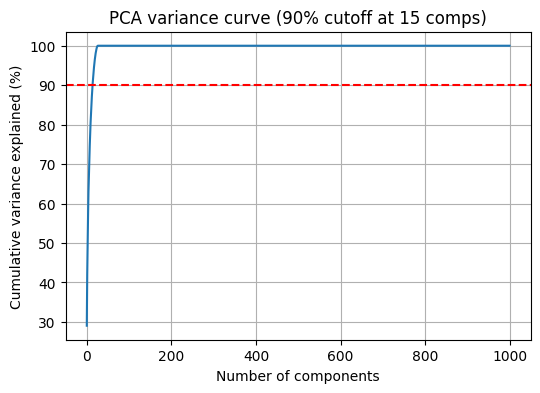


Computed metrics for 500 neurons.
At FDR=0.05, 2/500 neurons show AUC > 0.5 (significant).


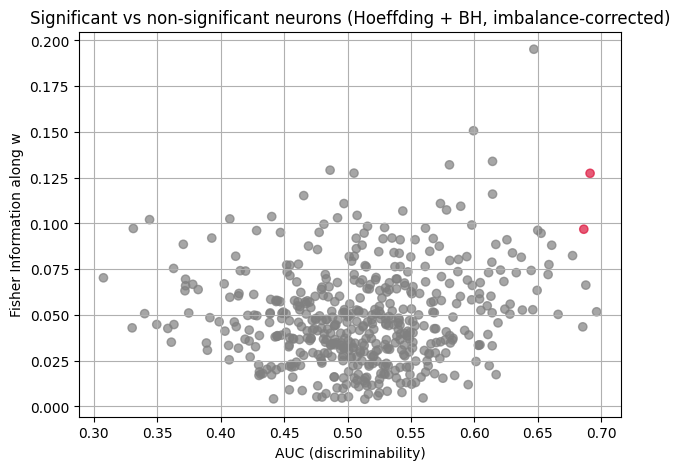


Summary statistics:
                     mean           std           min           max
neuron_idx   19525.856000  11244.473146  2.070000e+02  39154.000000
AUC              0.511961      0.064918  3.075473e-01      0.696422
Advantage        0.023921      0.129835 -3.849054e-01      0.392845
FI_trace       233.051365     10.030102  1.578617e+02    247.640759
FI_along_w       0.048529      0.026440  3.927123e-03      0.195202
EffectiveFI      0.001672      0.008850 -3.284460e-02      0.057367
m_pos           68.450000     52.662645  1.200000e+01    367.000000
n_neg         1331.550000     52.662645  1.033000e+03   1388.000000
p_value          0.831146      0.272738  6.741044e-07      1.000000
p_adj            0.987586      0.101375  3.370522e-04      1.000000

Top 10 significant neurons (imbalance-corrected):
     neuron_idx       AUC  m_pos  n_neg       p_value     p_adj
78        32302  0.691263    233   1167  6.741044e-07  0.000337
100       27167  0.686316    191   1209  1.063310e-0

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from skbio.stats.composition import clr
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from sklearn.exceptions import ConvergenceWarning
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
import pickle, warnings

# ---------------------------------------------------------------
#  Setup
# ---------------------------------------------------------------
warnings.filterwarnings("ignore", category=ConvergenceWarning)
rng = np.random.default_rng(42)

# ---------------------------------------------------------------
#  Load data
# ---------------------------------------------------------------
dat = np.load('/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy')
print("dat shape (neurons x trials):", dat.shape)

path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

embeddings = np.stack(list(vit_dict))          # (118, 1000)
X = softmax(embeddings, axis=1)                # convert to probabilities

# ---------------------------------------------------------------
#  Trial structure
# ---------------------------------------------------------------
n_neurons, n_samples = dat.shape
n_images = 118
n_trials = 50
assert n_samples == n_images * n_trials

# Split by image identity (avoid leakage across trials)
img_indices = np.arange(n_images)
img_train, img_test = train_test_split(img_indices, test_size=28, random_state=42)
train_mask = np.isin(np.repeat(np.arange(n_images), n_trials), img_train)
test_mask  = np.isin(np.repeat(np.arange(n_images), n_trials), img_test)

# ---------------------------------------------------------------
#  Transform data
# ---------------------------------------------------------------
Y_binary = (dat > 0).astype(int)        # spike indicator
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)

# ---------------------------------------------------------------
#  Helper functions
# ---------------------------------------------------------------
def fisher_information_from_logreg(model, X):
    """Compute Fisher Information matrix for fitted logistic regression."""
    p = model.predict_proba(X)[:, 1]
    W = np.diag(p * (1 - p))
    return X.T @ W @ X / len(X)

def classifier_advantage(y_true, y_prob):
    """Return AUC and classifier advantage (2*(AUC-0.5))."""
    auc = roc_auc_score(y_true, y_prob)
    return auc, 2 * (auc - 0.5)

def hoeffding_pvalue(auc, m, n):
    """One-sided conservative p-value for H0: AUC <= 0.5."""
    delta = max(auc - 0.5, 0)
    if delta <= 0 or m == 0 or n == 0:
        return 1.0
    exponent = -2 * delta**2 / (1/m + 1/n)
    return float(np.exp(exponent))

# ---------------------------------------------------------------
#  Global PCA (before per-neuron loop)
# ---------------------------------------------------------------
pca_full = PCA()
pca_full.fit(X_trials_clr[test_mask])
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cum_var >= 0.90) + 1
print(f"\nPCA: {n_components_90} components explain ≥90% of the variance in the test set.")

# Fit PCA on training data (with that fixed dimensionality)
pca = PCA(n_components=n_components_90)
pca.fit(X_trials_clr[train_mask])

# Transform once
X_train_pca = pca.transform(X_trials_clr[train_mask])
X_test_pca  = pca.transform(X_trials_clr[test_mask])

# Optional visualization of explained variance
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_)*100)
plt.axhline(90, color='r', linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance explained (%)')
plt.title(f'PCA variance curve (90% cutoff at {n_components_90} comps)')
plt.grid(True)
plt.show()

# ---------------------------------------------------------------
#  Run per-neuron logistic regressions (store y_test / y_prob)
# ---------------------------------------------------------------
sampled_neurons = rng.choice(np.arange(n_neurons), size=500, replace=False)
results = []

for idx in sampled_neurons:
    y = Y_binary[idx]
    if y.sum() < 10 or y.sum() > len(y) - 10:
        continue

    y_train, y_test = y[train_mask], y[test_mask]

    model = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        penalty='l2',
        solver='liblinear'
    )

    try:
        model.fit(X_train_pca, y_train)
    except Exception:
        continue

    y_prob = model.predict_proba(X_test_pca)[:, 1]
    auc, adv = classifier_advantage(y_test, y_prob)

    I = fisher_information_from_logreg(model, X_train_pca)
    w = model.coef_.ravel()
    FI_trace = np.trace(I)
    FI_along_w = float(w @ I @ w)
    EffectiveFI = FI_along_w * (2 * auc - 1)

    m_pos = y_test.sum()
    n_neg = len(y_test) - m_pos
    p_val = hoeffding_pvalue(auc, m_pos, n_neg)

    results.append({
        "neuron_idx": idx,
        "AUC": auc,
        "Advantage": adv,
        "FI_trace": FI_trace,
        "FI_along_w": FI_along_w,
        "EffectiveFI": EffectiveFI,
        "m_pos": m_pos,
        "n_neg": n_neg,
        "p_value": p_val,
        "y_test": y_test.copy(),   # for diagnostics
        "y_prob": y_prob.copy()    # for diagnostics
    })

# ---------------------------------------------------------------
#  Analysis: Benjamini–Hochberg correction
# ---------------------------------------------------------------
df = pd.DataFrame(results)
print(f"\nComputed metrics for {len(df)} neurons.")

alpha = 0.05
reject, pvals_corrected, _, _ = multipletests(df["p_value"], alpha=alpha, method="fdr_bh")
df["p_adj"] = pvals_corrected
df["significant"] = reject

n_sig = df["significant"].sum()
print(f"At FDR={alpha}, {n_sig}/{len(df)} neurons show AUC > 0.5 (significant).")

# ---------------------------------------------------------------
#  Visualization
# ---------------------------------------------------------------
plt.figure(figsize=(7,5))
plt.scatter(df["AUC"], df["FI_along_w"],
            c=df["significant"].map({True:"crimson", False:"gray"}),
            alpha=0.7)
plt.xlabel("AUC (discriminability)")
plt.ylabel("Fisher Information along w")
plt.title("Significant vs non-significant neurons (Hoeffding + BH, imbalance-corrected)")
plt.grid(True)
plt.show()

# ---------------------------------------------------------------
#  Reports
# ---------------------------------------------------------------
print("\nSummary statistics:")
print(df.describe().T[["mean","std","min","max"]])

sig_neurons = df[df["significant"]].sort_values("AUC", ascending=False)
print("\nTop 10 significant neurons (imbalance-corrected):")
print(sig_neurons.head(10)[["neuron_idx", "AUC", "m_pos", "n_neg", "p_value", "p_adj"]])

top_clean = df.sort_values("EffectiveFI", ascending=False).head(10)
print("\nTop 10 cleanest neurons (high AUC & FI):")
print(top_clean[["neuron_idx","AUC","FI_along_w","EffectiveFI"]])



Diagnostics head:
   neuron_idx  m_pos  n_neg   AUC_obs  AUC_boot_mean  AUC_CI_lo  AUC_CI_hi  \
0        5423     78   1322  0.505280       0.504146   0.440080   0.560972   
1       31486     46   1354  0.544939       0.542612   0.464132   0.617730   
2       23351     93   1307  0.486261       0.487401   0.438845   0.539097   
3       24651     89   1311  0.407237       0.406806   0.349540   0.467262   
4       11409     53   1347  0.470297       0.471906   0.388702   0.556496   

      AUPRC  prevalence  PR_lift_norm  AUC_1to1  AUC_1to5  perm_p_auc  
0  0.056544    0.055714      0.000878  0.501348  0.505656    0.433566  
1  0.036628    0.032857      0.003899  0.540147  0.537595    0.137862  
2  0.063990    0.066429     -0.002612  0.484960  0.484005    0.660340  
3  0.051502    0.063571     -0.012889  0.405288  0.406598    1.000000  
4  0.038427    0.037857      0.000593  0.468049  0.465802    0.768232  


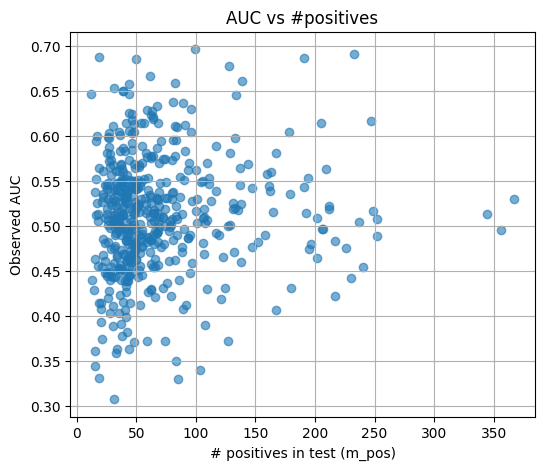

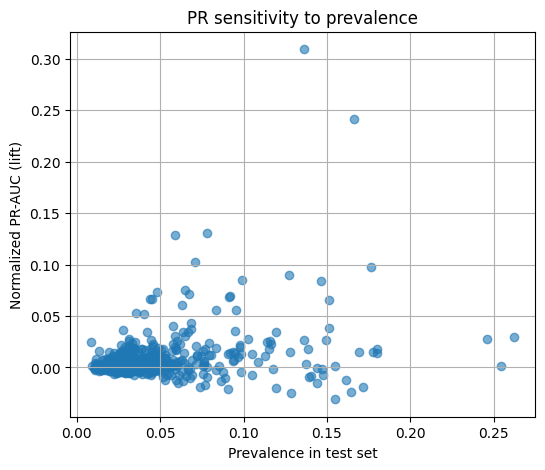


Potentially inflated-by-scarcity neurons:
Empty DataFrame
Columns: [neuron_idx, m_pos, n_neg, AUC_obs, AUC_boot_mean, AUC_CI_lo, AUC_CI_hi, AUPRC, prevalence, PR_lift_norm, AUC_1to1, AUC_1to5, perm_p_auc]
Index: []


In [10]:
# ==== (B) Diagnostics you can run after df = pd.DataFrame(results) ====
from sklearn.metrics import average_precision_score, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

df=pd.DataFrame(results)
def bootstrap_auc_ci(y_true, y_score, B=1000, seed=0):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    aucs = []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        try:
            aucs.append(roc_auc_score(y_true[idx], y_score[idx]))
        except:
            continue
    if len(aucs) == 0:
        return np.nan, np.nan, np.nan
    aucs = np.array(aucs)
    return float(np.mean(aucs)), float(np.quantile(aucs, 0.025)), float(np.quantile(aucs, 0.975))

def pr_lift(y_true, y_score):
    ap = average_precision_score(y_true, y_score)
    p = y_true.mean()  # prevalence
    # normalized PR-AUC (lift over baseline random = p)
    lift = (ap - p) / (1 - p) if p < 1 else np.nan
    return ap, p, lift

def auc_with_downsampled_negs(y_true, y_score, ratio=1.0, reps=50, seed=0):
    """Make negatives equal to ratio * positives; average AUC over reps."""
    rng = np.random.default_rng(seed)
    pos_idx = np.where(y_true == 1)[0]
    neg_idx = np.where(y_true == 0)[0]
    m = len(pos_idx)
    if m == 0 or len(neg_idx) == 0:
        return np.nan
    k = int(np.ceil(ratio * m))
    aucs = []
    for _ in range(reps):
        if k > len(neg_idx):  # cap
            take = len(neg_idx)
        else:
            take = k
        sel_neg = rng.choice(neg_idx, size=take, replace=False)
        sel = np.concatenate([pos_idx, sel_neg])
        try:
            aucs.append(roc_auc_score(y_true[sel], y_score[sel]))
        except:
            continue
    return float(np.mean(aucs)) if len(aucs) > 0 else np.nan

def permutation_pvalue_auc(y_true, y_score, perms=1000, seed=0):
    rng = np.random.default_rng(seed)
    obs = roc_auc_score(y_true, y_score)
    cnt = 0
    for _ in range(perms):
        y_perm = y_true.copy()
        rng.shuffle(y_perm)  # preserves counts
        try:
            a = roc_auc_score(y_perm, y_score)
            if a >= obs:
                cnt += 1
        except:
            pass
    return (cnt + 1) / (perms + 1), obs

# ---- Compute diagnostics per neuron (store in new columns) ----
diag_rows = []
for _, row in df.iterrows():
    # skip if we didn't store arrays
    if "y_test" not in row or "y_prob" not in row:
        continue
    y_true = np.array(row["y_test"])
    y_score = np.array(row["y_prob"])

    # Bootstrap CI
    auc_mean, auc_lo, auc_hi = bootstrap_auc_ci(y_true, y_score, B=1000, seed=123)

    # PR metrics
    ap, prevalence, pr_lift_norm = pr_lift(y_true, y_score)

    # Downsampled AUC at 1:1 and 1:5 neg:pos
    auc_bal_1to1 = auc_with_downsampled_negs(y_true, y_score, ratio=1.0, reps=50, seed=123)
    auc_bal_1to5 = auc_with_downsampled_negs(y_true, y_score, ratio=5.0, reps=50, seed=123)

    # Permutation p-value (conditional on counts)
    perm_p, auc_obs = permutation_pvalue_auc(y_true, y_score, perms=1000, seed=123)

    diag_rows.append({
        "neuron_idx": row["neuron_idx"],
        "m_pos": row["m_pos"],
        "n_neg": row["n_neg"],
        "AUC_obs": auc_obs,
        "AUC_boot_mean": auc_mean,
        "AUC_CI_lo": auc_lo,
        "AUC_CI_hi": auc_hi,
        "AUPRC": ap,
        "prevalence": prevalence,
        "PR_lift_norm": pr_lift_norm,
        "AUC_1to1": auc_bal_1to1,
        "AUC_1to5": auc_bal_1to5,
        "perm_p_auc": perm_p
    })

diag = pd.DataFrame(diag_rows)
print("\nDiagnostics head:")
print(diag.head())

# ---- Quick visuals ----
plt.figure(figsize=(6,5))
plt.scatter(diag["m_pos"], diag["AUC_obs"], alpha=0.6)
plt.xlabel("# positives in test (m_pos)")
plt.ylabel("Observed AUC")
plt.title("AUC vs #positives")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(diag["prevalence"], diag["PR_lift_norm"], alpha=0.6)
plt.xlabel("Prevalence in test set")
plt.ylabel("Normalized PR-AUC (lift)")
plt.title("PR sensitivity to prevalence")
plt.grid(True)
plt.show()

# Flag suspicious neurons: high AUC but (i) tiny m_pos, (ii) wide CI, (iii) collapses when balanced
suspicious = diag[
    (diag["m_pos"] < 10) &
    (diag["AUC_obs"] > 0.8) &
    ((diag["AUC_CI_hi"] - diag["AUC_CI_lo"]) > 0.2)
    |
    (np.isfinite(diag["AUC_1to1"]) & (diag["AUC_1to1"] < 0.65) & (diag["AUC_obs"] - diag["AUC_1to1"] > 0.15))
].sort_values(["m_pos","AUC_obs"], ascending=[True, False])

print("\nPotentially inflated-by-scarcity neurons:")
print(suspicious.head(15))
